In [14]:
import pickle as pkl
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns

import os
import sys

os.environ['CUDA_VISIBLE_DEVICES'] = ''
sys.path.append('..')

from evaluate import get_last_N, get_predictions, evaluate_model_ensembles, create_results_df

%matplotlib inline

In [79]:
df_full = pd.read_csv('../reports/result_df.csv')
print(df_full.shape)
df = df_full[df_full['num'].isna()].dropna(axis=1)
df = df[df['loss'] != 'mse']
print(df.shape)

(3561, 9)
(179, 8)


In [3]:
x, y = pkl.load(open('../data/yearly_24_train_line.pkl', 'rb'))

x.shape, y.shape

((176595, 18), (176595, 6))

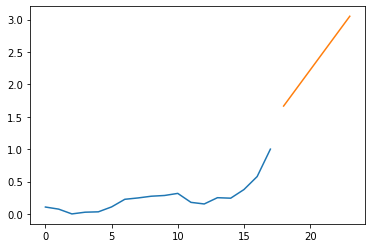

In [4]:
i = 8
plt.plot(range(18), x[i])
plt.plot(range(18, 24), y[i])

In [5]:
# Read test data
train_path = Path('../data/Yearly-train.csv')
test_path = Path('../data/Yearly-test.csv')

train = pd.read_csv(train_path).drop('V1', axis=1)
test = pd.read_csv(test_path).drop('V1', axis=1)

In [6]:
# Read experiments
p = Path('../results').absolute()

trials = [t for t in p.glob('*') if t.name.startswith('line')]
families = set([p / '__'.join(t.name.split('__')[:-1]) for t in trials])
num_models = [len(list(p.glob(f.name + '*'))) for f in families]

num_inputs = np.unique([f.name[10:12] for f in families])

In [12]:
for inp in num_inputs:
    X_test = np.array([get_last_N(ser[1], N=int(inp)) for ser in train.iterrows()])
    y_test = test.values

    curr_family_list = [(f, m) for f, m in zip(families, num_models) if f.name[10:12] == inp]

    results = evaluate_model_ensembles(curr_family_list, X_test, y_test)


100%|██████████| 14/14 [1:54:54<00:00, 492.49s/it]


In [24]:
results = {'smape': {k.replace('line__', ''): v for k, v in results['smape'].items()}}
results['mase'] = results['smape']

In [80]:
df2 = create_results_df(results).drop(['mase*'], axis=1)

In [81]:
df2['bottleneck_size'] = df2['bottleneck_size'].astype(int)

## Results for small bottlenecks

Text(0.5, 1.0, 'Results for small bottlenecks.')

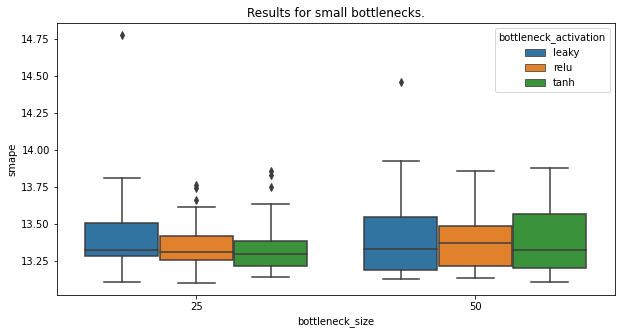

In [82]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='bottleneck_size', y='smape', hue='bottleneck_activation', 
            data=df2[(df2['bottleneck_size'] < 100) & (df2['output_len'] == '12')])

plt.title('Results for small bottlenecks.')

## Comparison with larger bottlenecks

Text(0.5, 1.0, 'Smaller/Larger bottleneck comparison ')

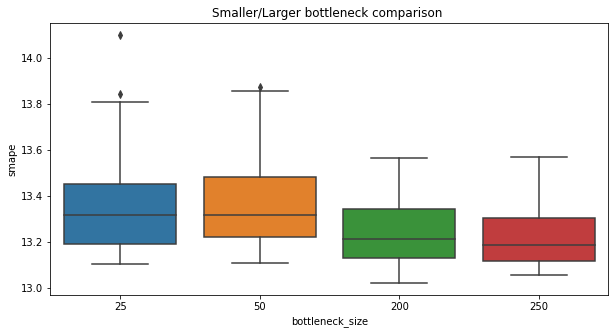

In [83]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='bottleneck_size', y='smape', data=df2[df2['bottleneck_activation'] == 'relu'])

plt.title('Smaller/Larger bottleneck comparison ')

## Investigate mistake

Text(0.5, 1.0, 'Large output')

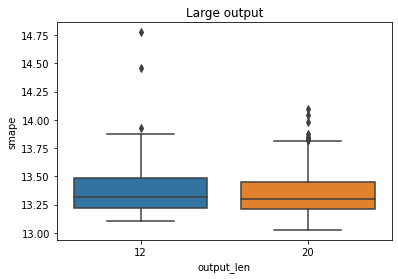

In [109]:
sns.boxplot(x='output_len', y='smape', data=df2[df2['bottleneck_size'] < 100])
plt.title('Large output')

## Compare Ensembles

In [84]:
df2['name'] = None

In [85]:
for j in range(len(df2)):
    df2.loc[j, 'name'] = '_'.join([str(i) for i in df2.drop(['smape', 'num', 'loss', 'LSTM_type', 'name'], axis=1).iloc[j]])

Text(0.5, 1.0, 'Line-ensembles performance')

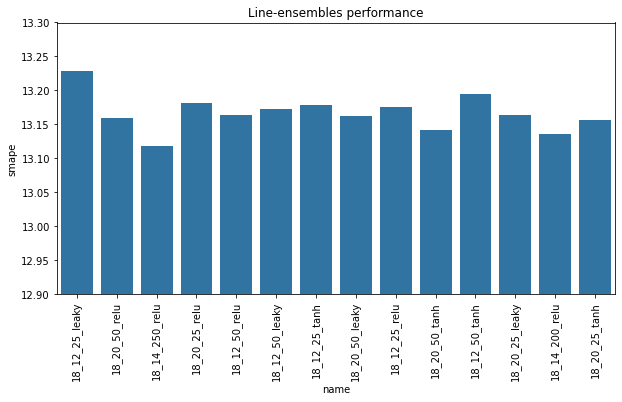

In [96]:
plt.figure(figsize=(10, 5))

sns.barplot(x='name', y='smape', data=df2[df2['num'].isna()], color='C0')
plt.xticks(rotation=90)
plt.ylim([12.9, 13.3])
plt.title('Line-ensembles performance')

In [111]:
df2.to_csv('../reports/lines.csv', index=False)

## Compare lines with regular

Text(0.5, 1.0, 'Ensembles with:\nInput: 18 and Output: 12')

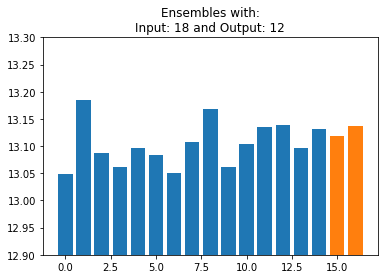

In [94]:
r = list(df[(df['input_len'] == 18) & (df['output_len'] == 14)]['smape'])  + \
    list(df2[(df2['input_len'] == '18') & (df2['output_len'] == '14') & df2['num'].isna()]['smape'])

colors = ['C0'] * (len(r) - 2) + ['C1'] * 2

plt.bar(range(len(r)), height=r, color=colors)
plt.ylim([12.9, 13.3])
plt.title('Ensembles with:\nInput: 18 and Output: 12')

In [102]:
a = df_full[(df_full['input_len'] == 18) & (df_full['output_len'] == 12) & (df_full['bottleneck_size'] == 200) & 
            (df_full['bottleneck_activation'] == 'relu') & (df_full['LSTM_type'] == 'bi') & (df_full['loss'] == 'mae')].dropna()

In [103]:
a['out_type'] = 'regular'
b = a[['out_type', 'smape']]

In [104]:
c = pd.DataFrame({'out_type': ['line']*30, 'smape': pd.DataFrame(results)[:30]['smape'].values})

Text(0.5, 1.0, 'Input: 18 - Output: 12 - Bottleneck: 200')

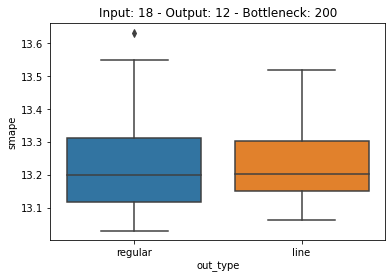

In [105]:
sns.boxplot(x='out_type', y='smape', data=pd.concat([b, c]))
plt.title('Input: 18 - Output: 12 - Bottleneck: 200')

Text(0.5, 1.0, 'Input: 18 - Output: 12 - Bottleneck: 250')

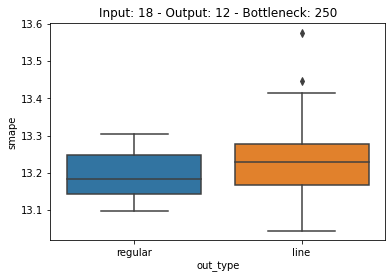

In [101]:
a = df_full[(df_full['input_len'] == 18) & (df_full['output_len'] == 14) & (df_full['bottleneck_size'] == 250) & 
            (df_full['bottleneck_activation'] == 'relu') & (df_full['LSTM_type'] == 'bi') & (df_full['loss'] == 'mae')].dropna()
a['out_type'] = 'regular'
b = a[['out_type', 'smape']]
c = pd.DataFrame({'out_type': ['line']*30, 'smape': pd.DataFrame(results)[31:-1]['smape'].values})

sns.boxplot(x='out_type', y='smape', data=pd.concat([b, c]))
plt.title('Input: 18 - Output: 12 - Bottleneck: 250')